In [61]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [62]:
import numpy as np
import pandas as pd

In [63]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [64]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [65]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [66]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [67]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [68]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [69]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23 00:00:00
2016-08-22 00:00:00


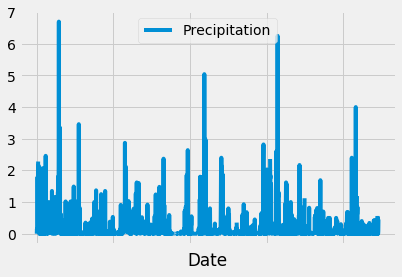

In [70]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
print(last_date)

year_ago = last_date - dt.timedelta(days=366)
print(year_ago)

prcp_date = session.query(Measurement.prcp,Measurement.date).filter(Measurement.date >= year_ago).\
            order_by(Measurement.date).all()

prcp1 = pd.DataFrame(prcp_date, columns=["Precipitation", "Date"])

prcp1.set_index(["Date"], inplace = True, drop = True)

prcp1.sort_index(inplace=True)

prcp1.plot()
plt.legend(loc="best")

plt.show()

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df = pd.DataFrame(prcp1.Precipitation.describe())
prcp_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [39]:
# Design a query to show how many stations are available in this dataset?
stations_available = session.query(func.count(Station.station)).all()
stations_available

[(9)]

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
                  join(Station,Station.station == Measurement.station).\
                  group_by(Measurement.station,Station.name).order_by(func.count(Measurement.station).desc()).all()

active_stdf = pd.DataFrame(active_stations, columns=["Station", "Station Name", "Count"])
active_stdf

,Station,Station Name,Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_result = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
         filter(Measurement.station == active_stations[0][0]).all()

temp_resultpd = pd.DataFrame(temp_result, columns=["station_ID", "min_temp", "max_temp", "avg_temp"])
temp_resultpd

,station_ID,min_temp,max_temp,avg_temp
0,USC00519281,54.0,85.0,71.663781


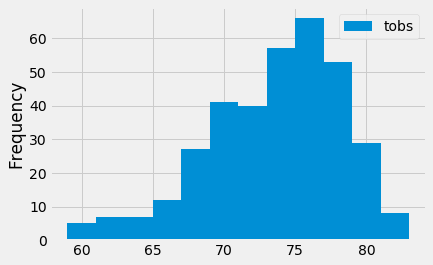

In [72]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs1 = session.query(Measurement.tobs).filter(Measurement.date > year_ago).filter(Measurement.station == active_stations[0][0]).all()

tobs = [i[0] for i in tobs1]

plt.hist(tobs,bins=12)

plt.ylabel("Frequency")
labels= ["tobs"]
plt.legend(labels)
plt.show()



In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [52]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = '2017-02-01'
trip_end = '2017-02-17'

ctemp = calc_temps(trip_start, trip_end)[0]
minT, avgT, maxT = ctemp
print(minT, avgT, maxT)
print(maxT - minT)

59.0 69.90090090090091 80.0
21.0


Text(0,0.5,'Temp (F)')

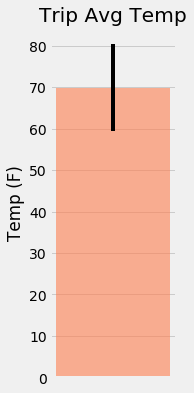

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


plt.figure(figsize=[2,6])
plt.bar(x=0, height=avgT, yerr=(maxT-minT)/2, color = 'coral', alpha=.6)
plt.grid(axis='x')
plt.xticks([])
plt.title('Trip Average Temp')
plt.ylabel('Temp (F)')

In [74]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_start = '2017-02-01'
trip_end = '2017-02-17'


rainfall = session.query(Station.station, Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
                  join(Measurement,Measurement.station == Station.station).\
                  filter(Measurement.date >= trip_start ).\
                  filter(Measurement.date <= trip_end ).\
                  group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
                  order_by(func.sum(Measurement.prcp).desc()).all()

rainfalldf = pd.DataFrame(rainfall, columns=["Station", "Station Name", "Latitude","Longitude","Elevation", "PSum"])
rainfalldf

,Station,Station Name,Latitude,Longitude,Elevation,PSum
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,8.11
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,7.64
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,7.09
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,5.92
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.56
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,3.52
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


## Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

    MinT       AvgT  MaxT
0   56.0  68.140351  78.0
1   59.0  68.859649  77.0
2   58.0  67.796610  77.0
3   61.0  68.140351  76.0
4   59.0  69.684211  80.0
5   58.0  70.389831  77.0
6   60.0  69.000000  77.0
7   56.0  66.754386  74.0
8   57.0  67.589286  75.0
9   56.0  68.416667  76.0
10  61.0  69.250000  79.0
11  60.0  69.157895  78.0
12  58.0  70.362069  80.0
13  62.0  70.894737  79.0
14  56.0  70.288136  79.0
15  59.0  70.482143  76.0
16  62.0  70.472727  77.0


Text(0.5,0,'Date')

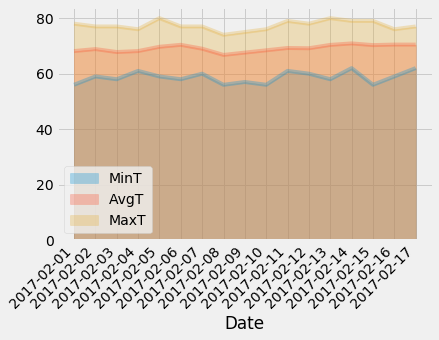

In [76]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

trip_start = '2017-02-01'
trip_end = '2017-02-17'

trip_start_date = dt.datetime.strptime(trip_start, "%Y-%m-%d")
trip_end_date = dt.datetime.strptime(trip_end, "%Y-%m-%d")
date_range = []

while (trip_end_date >= trip_start_date):
    date_range.append(dt.datetime.strftime(trip_start_date, '%Y-%m-%d'))
    trip_start_date += dt.timedelta(days=1)
    
values = []

for i in date_range:
    val = i[5:]
    values.append(daily_normals(val)[0])
    
pd_values = pd.DataFrame(values, columns = ['MinT', 'AvgT', 'MaxT'])
print(pd_values)
ticks = np.arange(0,17)

pd_values.plot.area(stacked=False, alpha = .3)
plt.xticks(ticks, date_range, rotation = 45, horizontalalignment = 'right')
plt.xlabel('Date')

In [58]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
pd_values = pd_values.assign(Date = date_range)
pd_values.set_index(["Date"], inplace = True, drop = True)
pd_values

,MinT,AvgT,MaxT
Date,,,
2017-02-01,56.0,68.140351,78.0
2017-02-02,59.0,68.859649,77.0
2017-02-03,58.0,67.796610,77.0
2017-02-04,61.0,68.140351,76.0
2017-02-05,59.0,69.684211,80.0
2017-02-06,58.0,70.389831,77.0
2017-02-07,60.0,69.000000,77.0
2017-02-08,56.0,66.754386,74.0
2017-02-09,57.0,67.589286,75.0
